<a href="https://colab.research.google.com/github/PTC-Education/PTC-API-Playground/blob/main/Configuration_Variables_and_Google_Sheets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Onshape

Configure client and define functions

In [1]:
#@title Import and Setup Onshape Client

!pip install onshape-client
from onshape_client.client import Client
from onshape_client.onshape_url import OnshapeElement
import json

#@markdown Chage the base if using an enterprise (i.e. "https://ptc.onshape.com")
base = 'https://cad.onshape.com' #@param {type:"string"}

#@markdown Would you like to import your API keys from a file, or copy and paste them directly?
keyImportOption = "Upload Keys from File" #@param ["Upload Keys from File", "Copy/Paste Keys"]

from IPython.display import clear_output 
clear_output()
print("Onshape Client successfully imported!")

if keyImportOption == "Upload Keys from File":
  from google.colab import files
  uploaded = files.upload()
  for fn in uploaded.keys():
    execfile(fn)

  client = Client(configuration={"base_url": base,
                                "access_key": access,
                                "secret_key": secret})
  clear_output()
  print('Onshape client configured - ready to go!')
else:
  access = input("Paste your Onshape Access Key: ")
  secret = input("Paste your Onshape Secret Key: ")
  client = Client(configuration={"base_url": base,
                                "access_key": access,
                                "secret_key": secret})
  clear_output()
  print('Onshape client configured - ready to go!')


Onshape client configured - ready to go!


In [ ]:
#@title Get Mass Properties of Parts in a Part Studio
#@markdown Defines funciton `getMassProp(url: str)`, which returns JSON of mass properties for all parts in a part studio
url = 'https://cad.onshape.com/documents/263517311c2ad139d4eb57ca/w/b45057ae06777e0c28bca6c5/e/d316bcbc694c9dbb6555f340' #@param {type:"string"}
showResponse = False #@param {type:"boolean"}

def getMassProp(url: str, params = {}):
  fixed_url = '/api/partstudios/d/did/w/wid/e/eid/massproperties'
  element = OnshapeElement(url)
  method = 'GET'

  payload = {}
  headers = {'Accept': 'application/vnd.onshape.v1+json; charset=UTF-8;qs=0.1',
            'Content-Type': 'application/json'}

  fixed_url = fixed_url.replace('did', element.did)
  fixed_url = fixed_url.replace('wid', element.wvmid)
  fixed_url = fixed_url.replace('eid', element.eid)

  response = client.api_client.request(method, url=base + fixed_url, query_params=params, headers=headers, body=payload)

  parsed = json.loads(response.data)
  return parsed
if showResponse:
  massProp = getMassProp(url)
  print(json.dumps(massProp, indent=4, sort_keys=True))
else:
  pass

# Sheets

Authorize google sheets and define functions

In [11]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [12]:
worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1dJcIlzYdoqfApjX59anfoE-kYtzBeF_yeyaxTBUcuj8/edit#gid=0').sheet1

# Main

In [ ]:
from gspread_dataframe import set_with_dataframe
import pandas as pd

data = worksheet.get_all_values()
headers = data.pop(0)

df = pd.DataFrame(data, columns=headers)
for i,x in enumerate(df['Var1']):
  configdef = 'Length%3D'+str(x)+'%2Bmeter'+';'+'Width%3D'+str(df['Var2'][i])+'%2Bmeter'
  params = {'configuration': configdef}

  massProp = getMassProp(url, params)
  df['Volume'][i] = massProp['bodies']['-all-']['volume'][0]

set_with_dataframe(worksheet,df)

Do the same but plot with matplotlib

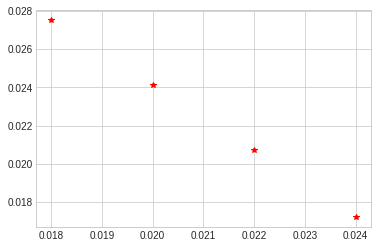

In [23]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

x = np.arange(0.018,0.026,0.002)
val = []

url = "https://cad.onshape.com/documents/976596e461d9f2a327329abe/w/f8cedddfd3a0c744d9c5bbff/e/a1d793ce5edd998cf6644248"

for i in x:
  configdef = 'SHK%3D'+str(i)+'%2Bmeter'
  params = {'configuration': configdef}

  vars = test_get_variable(url,configdef)
  val.append(float(vars[0]['Vert_position'].strip("*meters")))

plt.plot(x, val, '*', color='red');

In [21]:
# USING CODE FROM https://github.com/onshape-public/onshape-clients/blob/master/python/test/test_get_variables.py
# GET VARIABLE (IN THIS CASE ALL THOSE WTH THE 'M' LABEL)

import json

from onshape_client.oas import BTFeatureScriptEvalCall2377
from onshape_client.onshape_url import OnshapeElement
from onshape_client.utility import parse_quantity

x=[]
y=[]
yy=[]


script = r"""
    function(context, queries) {
            return getVariable(context, 'm');
        }
    """
def test_get_variable(url, params):
    element = OnshapeElement(url)
    script_call = BTFeatureScriptEvalCall2377(script=script)
    response = client.part_studios_api.eval_feature_script(
        element.did,
        element.wvm,
        element.wvmid,
        element.eid,
        bt_feature_script_eval_call_2377=script_call,
        _preload_content=False,
        configuration=params
    )
    measurements = json.loads(response.data.decode("utf-8"))["result"]["message"]["value"]

    parsed_measurements = parse_variables_from_map(measurements)  
    vars = []
    for name, val in parsed_measurements.items():
        vars.append({name:val})
    return vars

def parse_variables_from_map(unparsed):
    parsed_variables = {}
    value = None
    for to_parse in unparsed:
        if is_fs_type(to_parse, "BTFSValueMapEntry"):
            key = to_parse["message"]["key"]["message"]["value"]
            candidate_message = to_parse["message"]["value"]
            if is_fs_type(candidate_message, ["BTFSValueMap", "BTFSValueArray"]):
                value = parse_variables_from_map(candidate_message["message"]["value"])
            elif is_fs_type(candidate_message, "BTFSValueWithUnits"):
                value = parse_quantity(candidate_message["message"])
            parsed_variables[key] = value
    return parsed_variables

def is_fs_type(candidate, type_name):
    result = False
    try:
        if isinstance(type_name, str):
            result = type_name == candidate["typeName"]
        elif isinstance(type_name, list):
            result = any(
                [type_name_one == candidate["typeName"] for type_name_one in type_name]
            )
    except Exception:
        result = False
    return result